# Detrended Fluctuation Analysis (DFA) Module

In [19]:
import array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Convert to mean-centered cumulative sum

In [5]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_Dec2020_Jun2023.csv'

df = pd.read_csv(files)
# Set timestamp as index
df = df.set_index(df['Time'])
df.drop(['Time'], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)

# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_13660\374198705.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,log_ret_sq
Time,,,,
2020-12-01 00:01:00,3654.045,1.932292,1.0,3.733753
2020-12-01 00:02:00,3654.336,0.796346,1.0,0.634167
2020-12-01 00:03:00,3653.945,-1.070019,1.0,1.144941
2020-12-01 00:04:00,3653.845,-0.273681,1.0,0.074901
2020-12-01 00:05:00,3653.299,-1.494428,1.0,2.233315
...,...,...,...,...
2023-06-30 16:09:00,4446.311,-1.171689,1.0,1.372856
2023-06-30 16:10:00,4445.570,-1.666689,1.0,2.777852
2023-06-30 16:11:00,4445.332,-0.535379,1.0,0.286630


<AxesSubplot:xlabel='Time'>

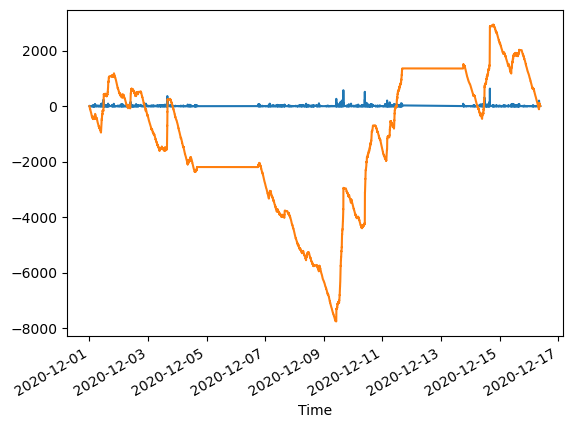

In [81]:
n_sample = 60 * 24 * 10

dfa = pd.DataFrame(df_1min['log_ret_sq'][:n_sample], columns = ['log_ret_sq'])
dfa['mean'] = [dfa['log_ret_sq'].mean()] * n_sample
dfa['mean_centered'] = dfa['log_ret_sq'] - dfa['mean']
dfa['mean_centered_cum_sum'] = dfa['mean_centered']
dfa['mean_centered_cum_sum'] = dfa['mean_centered_cum_sum'].cumsum()

dfa['log_ret_sq'].plot()
dfa['mean_centered_cum_sum'].plot()

## 2. Define log-spaced 'scales'

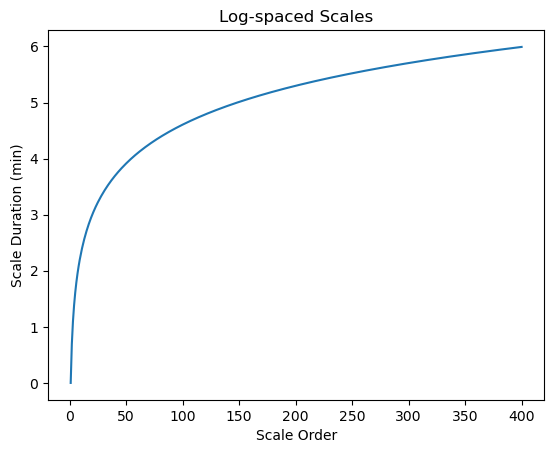

In [78]:
epoch_size = 400
duration = np.array([i for i in range(1, epoch_size+1)])
scales = np.divide(n_sample, duration).astype(int)
log_duration = np.log(duration)
log_scales = np.log(scales)
n_scales = len(scales)

plt.plot(range(1, n_scales+1), log_duration)
plt.xlabel('Scale Order')
plt.ylabel('Scale Duration (min)')
plt.title('Log-spaced Scales')

plt.show()

## 3. Split sample into epochs, detrend, compute RMS

In [79]:
epoch_list = ['epoch_' + str(i) for i in range(1, 1+epoch_size*2)]  
step_3 = pd.DataFrame(index=epoch_list)
step_3['size'] = 

SyntaxError: invalid syntax (1635841291.py, line 3)

In [80]:
scales

array([1440,  720,  480,  360,  288,  240,  205,  180,  160,  144,  130,
        120,  110,  102,   96,   90,   84,   80,   75,   72,   68,   65,
         62,   60,   57,   55,   53,   51,   49,   48,   46,   45,   43,
         42,   41,   40,   38,   37,   36,   36,   35,   34,   33,   32,
         32,   31,   30,   30,   29,   28,   28,   27,   27,   26,   26,
         25,   25,   24,   24,   24,   23,   23,   22,   22,   22,   21,
         21,   21,   20,   20,   20,   20,   19,   19,   19,   18,   18,
         18,   18,   18,   17,   17,   17,   17,   16,   16,   16,   16,
         16,   16,   15,   15,   15,   15,   15,   15,   14,   14,   14,
         14,   14,   14,   13,   13,   13,   13,   13,   13,   13,   13,
         12,   12,   12,   12,   12,   12,   12,   12,   12,   12,   11,
         11,   11,   11,   11,   11,   11,   11,   11,   11,   10,   10,
         10,   10,   10,   10,   10,   10,   10,   10,   10,   10,   10,
         10,    9,    9,    9,    9,    9,    9,   

In [77]:
scales_reverse = scales[::-1]
scales_reverse

array([   1,    1,    1, ...,  480,  720, 1440])

In [72]:
# First half
for i in range(1, 1+epoch_size):
    pass
a = pd.DataFrame(np.zeros((2,3)))
a

,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0


,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7,epoch_8,epoch_9,epoch_10,...,epoch_2391,epoch_2392,epoch_2393,epoch_2394,epoch_2395,epoch_2396,epoch_2397,epoch_2398,epoch_2399,epoch_2400
